Number of frames to process: 1
Type 1 for file input, 2 for randomly generated frames, 3 for all/no hits: 1


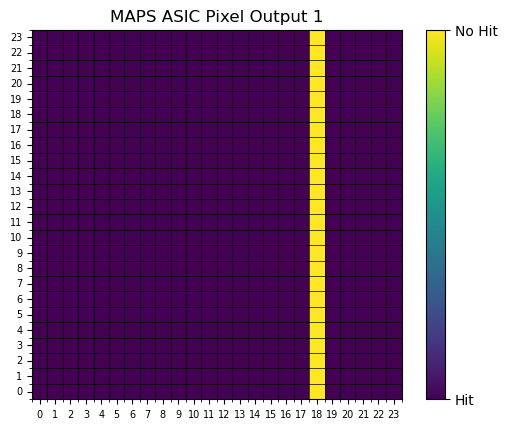

Average percent of hits in frame 1: 0.9583333333333334


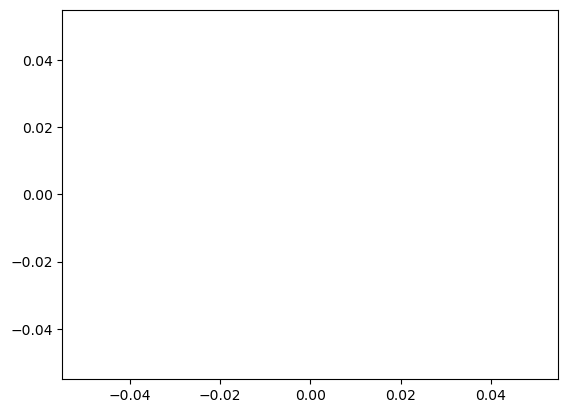

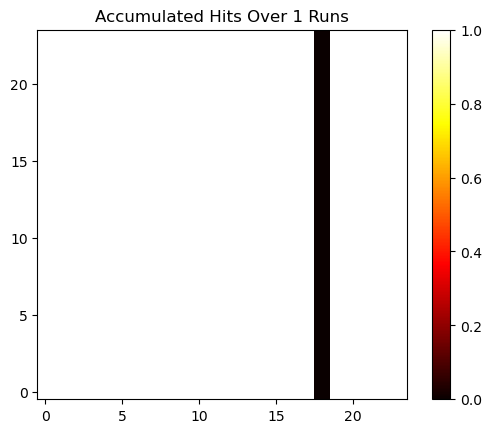

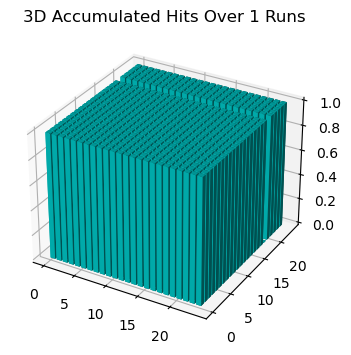

In [10]:
#imports and constants

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#constants

read_filename = 'pixOut.txt' # use your filename here
accumulated_hits = None
pix_dimension = 24 # pixels per side of sensor

#utility functions

# removes linebreaks from input file
def remove_linebreak(read):
    with open(read.strip('"'), 'r') as pix_out:
        pix_contents = pix_out.read()
    pix_string = pix_contents.replace('\n', '')
    return pix_string

# breaks one long string into a series of n*n length strings
def make_frames(string, num_frames):
    frame_size = len(string) // num_frames
    frames = [string[i:i + frame_size] for i in range(0, len(string), frame_size)]
    return frames

# turns an n*n length string into an nxn array
def str_to_array(frame_string, dimension):
    numbers_list = [int(num) for num in frame_string]
    n_array = np.array(numbers_list).reshape(dimension, dimension)
    return n_array

# generates n binary digits for use in randomly generated frames
def generate_random_binary_digits(n):
    return np.random.choice([0, 1], n)

#data loading and processing

# generates random data for plotting
def gen_random_data(number_frames):
    frame_size = pix_dimension**2
    total_size = number_frames * frame_size
    pix_string = generate_random_binary_digits(total_size)
    frames = [pix_string[i:i + frame_size] for i in range(0, total_size, frame_size)]
    data = [np.array([int(i) for i in frame]).reshape(pix_dimension, pix_dimension) for frame in frames]
    return data

# loads data from the specified file for plotting
def load_file(number_frames):
    pix_string = remove_linebreak(read_filename)
    frames = make_frames(pix_string, number_frames)
    data = [np.array([int(i) for i in frame]).reshape(pix_dimension, pix_dimension) for frame in frames]
    return data

# creates a number of frames filled entirely with 0s or 1s for plotting
def gen_fill(fill_choice, number_frames):
    if fill_choice == 0:
        pix_string = '0' * (number_frames * pix_dimension**2)
    else:
        pix_string = '1' * (number_frames * pix_dimension**2)
    frames = make_frames(pix_string, number_frames)
    data = [np.array([int(i) for i in frame]).reshape(pix_dimension, pix_dimension) for frame in frames]
    return data

#visualization

# plots the generated data with middle tickmarks to denote pixels
def plot_frame(array, frame_number, pix_dimension=pix_dimension):
    frame_data = array[frame_number]
    color_map = plt.cm.viridis
    plt.imshow(frame_data, cmap=color_map, extent=[0, pix_dimension, 0, pix_dimension])
    plt.title(f"MAPS ASIC Pixel Output {frame_number+1}")

    x_locator = ticker.MultipleLocator(base=1.0)
    y_locator = ticker.MultipleLocator(base=1.0)

    x_formatter = ticker.ScalarFormatter(useOffset=False)
    y_formatter = ticker.ScalarFormatter(useOffset=False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    ax.yaxis.set_major_formatter(y_formatter)

    ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))

    plt.grid(which='minor', linestyle='-', linewidth=0.5, color='black')
    plt.grid(which='major', linestyle='-', linewidth=0, color='black')

    ax.set_xticks(np.arange(pix_dimension) + 0.5, minor=False)
    ax.set_yticks(np.arange(pix_dimension) + 0.5, minor=False)
    ax.set_xticklabels([str(j) for j in range(pix_dimension)], fontsize=7, ha='center')
    ax.set_yticklabels([str(j) for j in range(pix_dimension)], fontsize=7, va='center')

    cbar = plt.colorbar(ticks=[0, 1])
    cbar.set_ticklabels(['Hit', 'No Hit'])
    plt.show()

# displays averages for generated frames
def averages_list(data): 
    averages_list = [np.mean(frame) for frame in data]
    for i, average in enumerate(averages_list):
        print(f"Average percent of hits in frame {i+1}: {1-average}")
    return averages_list

# displays a histogram of the generated averages
def plot_histogram(data, bins=54, range_vals=(.40625, .59325), 
                   color='skyblue', edgecolor='black', density=True):
    fig, ax = plt.subplots()
    ax.hist(data, bins=bins, range=range_vals, density=density, edgecolor=edgecolor, color=color)
    plt.show()
    return fig, ax

# creates heatmap data aggregated from the number of frames generated
def heatmap_data(data, number_frames):
    accumulated_hits = np.zeros((pix_dimension, pix_dimension), dtype=int)
    for frame in data:
        accumulated_hits += np.logical_not(frame)
    return accumulated_hits

# plots generated heatmap data
def plot_heatmap(accumulated_hits, number_frames):
    fig = plt.figure()
    plt.imshow(accumulated_hits, cmap='hot', vmin=0, vmax=(number_frames), origin='lower')
    plt.colorbar()
    plt.title(f"Accumulated Hits Over {number_frames} Runs")
    plt.show()

# plots generated heatmap data more fancy-like
def plot_3d_heatmap(accumulated_hits, number_frames):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    xpos, ypos = np.meshgrid(np.arange(accumulated_hits.shape[0]), np.arange(accumulated_hits.shape[1]), indexing="ij")
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)
    dx = 0.75
    dy = 0.75
    dz = accumulated_hits.flatten()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='c')
    ax.set_title(f"3D Accumulated Hits Over {number_frames} Runs")
    ax.set_zlim(0, number_frames)
    plt.show()
    
#main

def main():
    number_frames = int(input("Number of frames to process: "))
    data_choice = int(input("Type 1 for file input, 2 for randomly generated frames, 3 for all/no hits: "))

    # uses data choice to generate the proper data
    if data_choice == 1:
        data = load_file(number_frames)
    elif data_choice == 2:
        data = gen_random_data(number_frames)
    elif data_choice == 3:
        fill_choice = int(input("Type 0 for all hits or 1 for no hits: "))
        data = gen_fill(fill_choice, number_frames)

    # plots generated data
    for i in range(number_frames):
        plot_frame(data, i)
    
    # generates averages list and plots histogram
    avgs = averages_list(data)
    plot_histogram(avgs)
    
    # generates heatmap data and plots 2d heatmap
    heat = heatmap_data(data, number_frames)
    plot_heatmap(heat, number_frames)
    
    # plots 3d heatmap with 2d heatmap data
    plot_3d_heatmap(heat, number_frames)

if __name__ == "__main__":
    main()

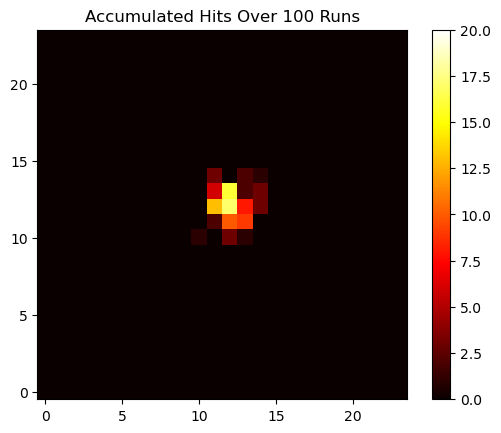

In [29]:
number_frames = 100

def gaussian_2d(x, y, mu_x, mu_y, sigma):
    return (1.0 / (2 * np.pi * sigma**2)) * np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))

def generate_random_binary_digits_for_circle():
    center_x, center_y = pix_dimension // 2, pix_dimension // 2
    hits = np.zeros((pix_dimension, pix_dimension))
    sigma = 1
    
    for x in range(pix_dimension):
        for y in range(pix_dimension):
            prob = gaussian_2d(x, y, center_x, center_y, sigma)
            hits[x, y] = 1 if np.random.random() < prob else 0
    
    return hits

accumulated_hits = np.zeros((pix_dimension, pix_dimension))
def simulate_n_runs():
    global accumulated_hits
    for _ in range(number_frames):
        frame = generate_random_binary_digits_for_circle()
        accumulated_hits += frame

simulate_n_runs()

fig = plt.figure()
plt.imshow(accumulated_hits, cmap='hot', vmin=0, vmax=(number_frames/5), origin='lower')
plt.colorbar()
plt.title(f"Accumulated Hits Over {number_frames} Runs")
plt.show()

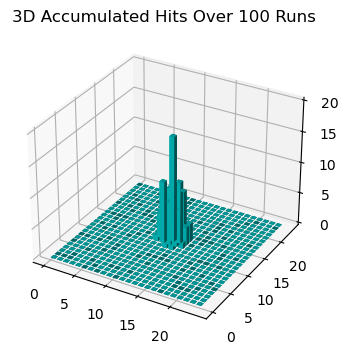

In [7]:
accumulated_hits = np.zeros((pix_dimension, pix_dimension))

def gaussian_2d(x, y, mu_x, mu_y, sigma):
    normalization = (1.0 / (2 * np.pi * sigma**2))
    exp_term = np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))
    return normalization * exp_term

def generate_random_binary_digits_within_circle(pix_dimension, radius, sigma):
    center_x, center_y = pix_dimension / 2, pix_dimension / 2
    data = np.zeros((pix_dimension, pix_dimension))
    
    for x in range(pix_dimension):
        for y in range(pix_dimension):
            if np.sqrt((x - center_x)**2 + (y - center_y)**2) <= radius:
                prob = gaussian_2d(x, y, center_x, center_y, sigma)
                if np.random.random() < prob:
                    data[x, y] = 1
    return data

def simulate_n_runs():
    global accumulated_hits
    for _ in range(number_frames):
        data = generate_random_binary_digits_within_circle(pix_dimension, 3, 1)
        accumulated_hits += data

simulate_n_runs()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

xpos, ypos = np.meshgrid(np.arange(accumulated_hits.shape[0]), np.arange(accumulated_hits.shape[1]), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = 0.75
dy = 0.75
dz = accumulated_hits.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='c')
ax.set_title(f"3D Accumulated Hits Over {number_frames} Runs")
ax.set_zlim(0, number_frames*.2)

plt.show()